In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random

C:\Users\lawir\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\lawir\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\lawir\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\lawir\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
np.random.seed(314)
tf.random.set_random_seed(314)
random.seed(314)

In [3]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 59 (that is 50+10-1) length
    # this last_sequence will be used to predict in future dates that are not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    # shift the last sequence by -1
    last_sequence = np.array(pd.DataFrame(last_sequence).shift(-1).dropna())
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    # return the result
    return result

In [4]:
def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [5]:
# panjang sequence
N_STEPS = 100
# jangka waktu perkiraan, hitungan hari
LOOKUP_STEP = 1
# rasio data test
TEST_SIZE = 0.2
# features yang dipake
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell, pake model lstm, bisa diganti
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout, rasio dropout neuron yang gk efektif
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss -> loss function, bisa diganti mse atau yang lainnya
LOSS = "huber_loss"
OPTIMIZER = "adam" #optimizer bisa diganti pake sgd atau yang lain
BATCH_SIZE = 64 #rasio batch
EPOCHS = 400 #epoch, makin banyak makin bagus tapi lama
# Apple stock market
ticker = "AAPL" #data real yang dipake data penjualan produk apple inc, bundle dengan yahoo finance
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [6]:
# buat folder buat simpen hasil dan logs training data
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [ ]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

model.save(os.path.join("results", model_name) + ".h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 7868 samples, validate on 1968 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/400
7808/7868 [============================>.] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.0211
Epoch 00001: val_loss improved from inf to 0.00037, saving model to results\2020-05-13_AAPL-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
7868/7868 [==============================] - 15s 2ms/sample - loss: 0.0012 - mean_absolute_error: 0.0211 - val_loss: 3.7315e-04 - val_mean_absolute_error: 0.0111
Epoch 2/400
7808/7868 [============================>.] - ETA: 0s - loss: 7.0916e-04 - mean_absolute_error: 0.0170
Epoch 00002: val_loss did not improve from 0.00037
7868/7868 [==============================] - 11s 1ms/sample - loss: 7.0583e-04 - mean_absolute_error: 0.0170 - val_loss: 4.4757e-04 - val_mean_absolute_e

Epoch 21/400
7808/7868 [============================>.] - ETA: 0s - loss: 2.0449e-04 - mean_absolute_error: 0.0110
Epoch 00021: val_loss did not improve from 0.00003
7868/7868 [==============================] - 14s 2ms/sample - loss: 2.0488e-04 - mean_absolute_error: 0.0111 - val_loss: 6.7453e-05 - val_mean_absolute_error: 0.0048
Epoch 22/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.7715e-04 - mean_absolute_error: 0.0102
Epoch 00022: val_loss did not improve from 0.00003
7868/7868 [==============================] - 15s 2ms/sample - loss: 1.7667e-04 - mean_absolute_error: 0.0102 - val_loss: 9.8429e-05 - val_mean_absolute_error: 0.0078
Epoch 23/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.7301e-04 - mean_absolute_error: 0.0103
Epoch 00023: val_loss did not improve from 0.00003
7868/7868 [==============================] - 11s 1ms/sample - loss: 1.7246e-04 - mean_absolute_error: 0.0103 - val_loss: 8.6978e-05 - val_mean_absolute_error: 0.0072
Epoc

Epoch 45/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.5813e-04 - mean_absolute_error: 0.0104
Epoch 00045: val_loss did not improve from 0.00002
7868/7868 [==============================] - 11s 1ms/sample - loss: 1.5801e-04 - mean_absolute_error: 0.0104 - val_loss: 1.1547e-04 - val_mean_absolute_error: 0.0084
Epoch 46/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.2767e-04 - mean_absolute_error: 0.0094
Epoch 00046: val_loss improved from 0.00002 to 0.00002, saving model to results\2020-05-13_AAPL-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
7868/7868 [==============================] - 11s 1ms/sample - loss: 1.2745e-04 - mean_absolute_error: 0.0094 - val_loss: 2.3180e-05 - val_mean_absolute_error: 0.0031
Epoch 47/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.1836e-04 - mean_absolute_error: 0.0090
Epoch 00047: val_loss did not improve from 0.00002
7868/7868 [==============================] - 12s 1ms/sample - loss:

Epoch 68/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.5206e-04 - mean_absolute_error: 0.0103
Epoch 00068: val_loss did not improve from 0.00002
7868/7868 [==============================] - 12s 2ms/sample - loss: 1.5230e-04 - mean_absolute_error: 0.0103 - val_loss: 7.1248e-05 - val_mean_absolute_error: 0.0100
Epoch 69/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.5879e-04 - mean_absolute_error: 0.0102
Epoch 00069: val_loss did not improve from 0.00002
7868/7868 [==============================] - 19s 2ms/sample - loss: 1.5873e-04 - mean_absolute_error: 0.0102 - val_loss: 4.9069e-05 - val_mean_absolute_error: 0.0054
Epoch 70/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.4250e-04 - mean_absolute_error: 0.0100
Epoch 00070: val_loss did not improve from 0.00002
7868/7868 [==============================] - 20s 2ms/sample - loss: 1.4177e-04 - mean_absolute_error: 0.0099 - val_loss: 6.0511e-05 - val_mean_absolute_error: 0.0070
Epoc

Epoch 93/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.4114e-04 - mean_absolute_error: 0.0101
Epoch 00093: val_loss did not improve from 0.00002
7868/7868 [==============================] - 13s 2ms/sample - loss: 1.4129e-04 - mean_absolute_error: 0.0101 - val_loss: 4.0567e-05 - val_mean_absolute_error: 0.0073
Epoch 94/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.5103e-04 - mean_absolute_error: 0.0105
Epoch 00094: val_loss did not improve from 0.00002
7868/7868 [==============================] - 13s 2ms/sample - loss: 1.5153e-04 - mean_absolute_error: 0.0105 - val_loss: 3.1096e-05 - val_mean_absolute_error: 0.0037
Epoch 95/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.3131e-04 - mean_absolute_error: 0.0092
Epoch 00095: val_loss did not improve from 0.00002
7868/7868 [==============================] - 13s 2ms/sample - loss: 1.3068e-04 - mean_absolute_error: 0.0092 - val_loss: 5.2387e-05 - val_mean_absolute_error: 0.0044
Epoc

7808/7868 [============================>.] - ETA: 0s - loss: 1.1919e-04 - mean_absolute_error: 0.0092
Epoch 00117: val_loss did not improve from 0.00002
7868/7868 [==============================] - 15s 2ms/sample - loss: 1.1870e-04 - mean_absolute_error: 0.0092 - val_loss: 1.9069e-05 - val_mean_absolute_error: 0.0037
Epoch 118/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.1633e-04 - mean_absolute_error: 0.0089
Epoch 00118: val_loss did not improve from 0.00002
7868/7868 [==============================] - 15s 2ms/sample - loss: 1.1577e-04 - mean_absolute_error: 0.0089 - val_loss: 3.2445e-05 - val_mean_absolute_error: 0.0053
Epoch 119/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.3359e-04 - mean_absolute_error: 0.0093
Epoch 00119: val_loss did not improve from 0.00002
7868/7868 [==============================] - 14s 2ms/sample - loss: 1.3396e-04 - mean_absolute_error: 0.0093 - val_loss: 6.9297e-05 - val_mean_absolute_error: 0.0066
Epoch 120/400
7

Epoch 142/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.2546e-04 - mean_absolute_error: 0.0091
Epoch 00142: val_loss did not improve from 0.00002
7868/7868 [==============================] - 16s 2ms/sample - loss: 1.2543e-04 - mean_absolute_error: 0.0091 - val_loss: 2.2005e-05 - val_mean_absolute_error: 0.0033
Epoch 143/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.2833e-04 - mean_absolute_error: 0.0092
Epoch 00143: val_loss did not improve from 0.00002
7868/7868 [==============================] - 15s 2ms/sample - loss: 1.2911e-04 - mean_absolute_error: 0.0092 - val_loss: 3.5529e-05 - val_mean_absolute_error: 0.0039
Epoch 144/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.0364e-04 - mean_absolute_error: 0.0085
Epoch 00144: val_loss did not improve from 0.00002
7868/7868 [==============================] - 15s 2ms/sample - loss: 1.0404e-04 - mean_absolute_error: 0.0085 - val_loss: 2.3117e-05 - val_mean_absolute_error: 0.0034
E

Epoch 167/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.1283e-04 - mean_absolute_error: 0.0088
Epoch 00167: val_loss did not improve from 0.00002
7868/7868 [==============================] - 15s 2ms/sample - loss: 1.1276e-04 - mean_absolute_error: 0.0088 - val_loss: 6.8231e-05 - val_mean_absolute_error: 0.0051
Epoch 168/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.2196e-04 - mean_absolute_error: 0.0088
Epoch 00168: val_loss did not improve from 0.00002
7868/7868 [==============================] - 15s 2ms/sample - loss: 1.2142e-04 - mean_absolute_error: 0.0088 - val_loss: 2.9474e-05 - val_mean_absolute_error: 0.0041
Epoch 169/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.2711e-04 - mean_absolute_error: 0.0091
Epoch 00169: val_loss did not improve from 0.00002
7868/7868 [==============================] - 16s 2ms/sample - loss: 1.2642e-04 - mean_absolute_error: 0.0091 - val_loss: 3.1675e-05 - val_mean_absolute_error: 0.0039
E

Epoch 192/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.0786e-04 - mean_absolute_error: 0.0085
Epoch 00192: val_loss did not improve from 0.00002
7868/7868 [==============================] - 17s 2ms/sample - loss: 1.0842e-04 - mean_absolute_error: 0.0086 - val_loss: 4.9746e-05 - val_mean_absolute_error: 0.0059
Epoch 193/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.2797e-04 - mean_absolute_error: 0.0090
Epoch 00193: val_loss did not improve from 0.00002
7868/7868 [==============================] - 17s 2ms/sample - loss: 1.2741e-04 - mean_absolute_error: 0.0090 - val_loss: 2.4285e-05 - val_mean_absolute_error: 0.0040
Epoch 194/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.0954e-04 - mean_absolute_error: 0.0086
Epoch 00194: val_loss did not improve from 0.00002
7868/7868 [==============================] - 17s 2ms/sample - loss: 1.0921e-04 - mean_absolute_error: 0.0086 - val_loss: 2.5522e-05 - val_mean_absolute_error: 0.0031
E

7808/7868 [============================>.] - ETA: 0s - loss: 9.6131e-05 - mean_absolute_error: 0.0084- ETA: 2s - loss: 9.6991e-05 - mean_absolute
Epoch 00216: val_loss did not improve from 0.00002
7868/7868 [==============================] - 19s 2ms/sample - loss: 9.5732e-05 - mean_absolute_error: 0.0083 - val_loss: 2.1747e-05 - val_mean_absolute_error: 0.0035
Epoch 217/400
7808/7868 [============================>.] - ETA: 0s - loss: 9.6702e-05 - mean_absolute_error: 0.0083- ETA: 4s - loss: 9.5690e-05 -
Epoch 00217: val_loss did not improve from 0.00002
7868/7868 [==============================] - 18s 2ms/sample - loss: 9.6963e-05 - mean_absolute_error: 0.0083 - val_loss: 3.3474e-05 - val_mean_absolute_error: 0.0037
Epoch 218/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.1065e-04 - mean_absolute_error: 0.0088
Epoch 00218: val_loss did not improve from 0.00002
7868/7868 [==============================] - 18s 2ms/sample - loss: 1.1256e-04 - mean_absolute_error: 0.008

7808/7868 [============================>.] - ETA: 0s - loss: 1.0827e-04 - mean_absolute_error: 0.0085
Epoch 00239: val_loss did not improve from 0.00002
7868/7868 [==============================] - 21s 3ms/sample - loss: 1.0848e-04 - mean_absolute_error: 0.0085 - val_loss: 1.8828e-05 - val_mean_absolute_error: 0.0029
Epoch 240/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.0683e-04 - mean_absolute_error: 0.0086
Epoch 00240: val_loss did not improve from 0.00002
7868/7868 [==============================] - 19s 2ms/sample - loss: 1.0673e-04 - mean_absolute_error: 0.0086 - val_loss: 3.7978e-05 - val_mean_absolute_error: 0.0035
Epoch 241/400
7808/7868 [============================>.] - ETA: 0s - loss: 9.7039e-05 - mean_absolute_error: 0.0080
Epoch 00241: val_loss did not improve from 0.00002
7868/7868 [==============================] - 20s 3ms/sample - loss: 9.6596e-05 - mean_absolute_error: 0.0080 - val_loss: 1.8104e-05 - val_mean_absolute_error: 0.0033
Epoch 242/400
7

Epoch 263/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.0544e-04 - mean_absolute_error: 0.0086  ETA: 14s - loss:
Epoch 00263: val_loss did not improve from 0.00002
7868/7868 [==============================] - 23s 3ms/sample - loss: 1.0491e-04 - mean_absolute_error: 0.0086 - val_loss: 2.0538e-05 - val_mean_absolute_error: 0.0040
Epoch 264/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.1324e-04 - mean_absolute_error: 0.0087
Epoch 00264: val_loss did not improve from 0.00002
7868/7868 [==============================] - 21s 3ms/sample - loss: 1.1350e-04 - mean_absolute_error: 0.0087 - val_loss: 8.2789e-05 - val_mean_absolute_error: 0.0063
Epoch 265/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.0577e-04 - mean_absolute_error: 0.0086
Epoch 00265: val_loss did not improve from 0.00002
7868/7868 [==============================] - 22s 3ms/sample - loss: 1.0585e-04 - mean_absolute_error: 0.0086 - val_loss: 1.0475e-04 - val_mean_absolu

7808/7868 [============================>.] - ETA: 0s - loss: 1.1883e-04 - mean_absolute_error: 0.0088
Epoch 00283: val_loss did not improve from 0.00002
7868/7868 [==============================] - 22s 3ms/sample - loss: 1.1852e-04 - mean_absolute_error: 0.0088 - val_loss: 2.7875e-05 - val_mean_absolute_error: 0.0030
Epoch 284/400
7808/7868 [============================>.] - ETA: 0s - loss: 1.1427e-04 - mean_absolute_error: 0.0087  ETA: 18s - loss: 1.5325e-04 - mean_absolute_error: 0.00 - ETA: 17s - loss: 1.4699e-04 - mean_absolu - ETA: 16s - loss: 1.2504e-04 - mea
Epoch 00284: val_loss did not improve from 0.00002
7868/7868 [==============================] - 22s 3ms/sample - loss: 1.1401e-04 - mean_absolute_error: 0.0087 - val_loss: 7.1399e-05 - val_mean_absolute_error: 0.0056
Epoch 285/400
7808/7868 [============================>.] - ETA: 0s - loss: 9.8463e-05 - mean_absolute_error: 0.0082  ETA: 13s - loss: 1.0720e - ETA: 0s - loss: 9.8874e-05 - mean_absolute_error: 0.008 - ETA: 0s -

7808/7868 [============================>.] - ETA: 0s - loss: 9.2764e-05 - mean_absolute_error: 0.0080  ETA: 12s - loss: 9.375 - ETA: 9s
Epoch 00299: val_loss did not improve from 0.00002
7868/7868 [==============================] - 24s 3ms/sample - loss: 9.2568e-05 - mean_absolute_error: 0.0080 - val_loss: 2.0686e-05 - val_mean_absolute_error: 0.0033
Epoch 300/400
7808/7868 [============================>.] - ETA: 0s - loss: 9.1671e-05 - mean_absolute_error: 0.0080  - ETA: 11s - loss: 9.8754e-05 - mean_absolute_error: 0.00 - ETA: 11s - loss: 9.8084e-05 - ETA: 6s - loss: 9.5396e-05 - mean_absolute_error: 0.008 - ETA: 6s - loss: 9.5257e-
Epoch 00300: val_loss did not improve from 0.00002
7868/7868 [==============================] - 24s 3ms/sample - loss: 9.1397e-05 - mean_absolute_error: 0.0080 - val_loss: 2.6946e-05 - val_mean_absolute_error: 0.0030
Epoch 301/400
7808/7868 [============================>.] - ETA: 0s - loss: 9.4784e-05 - mean_absolute_error: 0.0081
Epoch 00301: val_loss di

In [35]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [36]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform(mae.reshape(1, -1))[0][0]
print("Mean Absolute Error:", mean_absolute_error)

Mean Absolute Error: 11.787807


In [37]:
def predict(model, data, classification=False):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][:N_STEPS]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price

In [38]:
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")

Future price after 30 days is 288.04$


In [39]:
def plot_graph(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    # last 200 days, feel free to edit that
    plt.plot(y_test[-200:], c='b')
    plt.plot(y_pred[-200:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

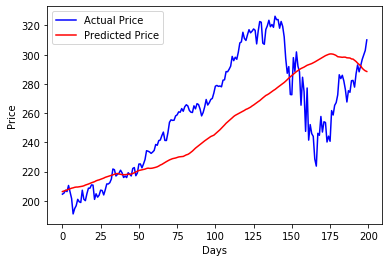

In [40]:
plot_graph(model, data)

In [41]:
def get_accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)

In [42]:
print(LOOKUP_STEP , ":", "Accuracy Score:", get_accuracy(model, data))

30 : Accuracy Score: 0.6069394096323149
